In [ ]:
import os
import pandas as pd
import requests
from urllib.parse import quote
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sb
sb.set_style('darkgrid')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
city = ['birmingham',
 'bristol',
 'buckinghamshire',
 'edinburgh',
 'glasgow',
 'gloucestershire',
 'hampshire',
 'liverpool',
 'london',
 'nottingham',
 'oxford',
 'sheffield',
 'aberdeenshire',
 'manchester']

lat_lon_tol = 0.6
api_key = 'pk.1a34e455dc7a1c2ce1b1b7c1da0877e7'
columns = ['id', 'bed', 'bath', 'reception', 'terrace', 'house', 'flat', 'bungalow', 'tenure', 'lat', 'lon', 'ch', 'dg', 'price']
folder = 'data'

super_df = pd.DataFrame(columns = columns)

for c in range(len(city)):
  main_df = pd.DataFrame()

  for i in os.listdir(os.path.join(os.getcwd(), 'drive', 'MyDrive', 'PC503_project', folder, city[c])):
    if '.xlsx' in i:
      if len(main_df) > 0:
        main_df = pd.concat([main_df, pd.read_excel(os.path.join(os.getcwd(), 'drive', 'MyDrive', 'PC503_project', folder, city[c], i))], ignore_index=True)
      else:
        main_df = pd.read_excel(os.path.join(os.getcwd(), 'drive', 'MyDrive', 'PC503_project', folder, city[c], i))

  main_df = main_df.drop('Unnamed: 0', axis = 1)

  length = len(main_df)

  x = f'https://eu1.locationiq.com/v1/search?key={api_key}&q={quote(city[c])}&format=json'
  y = requests.get(x)

  lat = float(y.json()[0]['lat'])
  lon = float(y.json()[0]['lon'])

  # main_df['lat'] = main_df['lat'].astype('float32')
  # remove all the columns where no values for price
  main_df = main_df.dropna(subset = ['price'])

  # drop rows where the house or flat or bungalow is not present
  check_df = main_df[ (main_df['house'] == 0) & (main_df['flat'] == 0) & (main_df['bungalow'] == 0) ].index
  main_df = main_df.drop(list(check_df))

  temp_df = pd.DataFrame(columns = columns)
  drop_index = []
  for i in range(len(main_df)):
    temp_dict = dict(main_df.iloc[i])

    change = False
    if not (abs(temp_dict['lat']) > (abs(lat) - lat_lon_tol) and abs(temp_dict['lat']) < (abs(lat) + lat_lon_tol)):
      temp_dict['lat'] = lat
      change = True
    
    if not (abs(temp_dict['lon']) > (abs(lon) - lat_lon_tol) and abs(temp_dict['lon']) < (abs(lon) + lat_lon_tol)):
      temp_dict['lon'] = lon
      change = True

    if change:
      drop_index.append(i)
      temp_df = pd.concat([temp_df, pd.DataFrame(temp_dict, index = [0])], ignore_index = True)

  main_df.reset_index(inplace= True)
  main_df = main_df.drop(drop_index)
  main_df = pd.concat([main_df, temp_df], ignore_index = True)
  main_df.drop('index', inplace = True, axis = 1)
  main_df.drop_duplicates(keep = 'first', inplace = True)

  # main_df.to_excel(os.path.join(os.getcwd(), 'drive', 'MyDrive', 'PC503_project', 'data', f'{city[c]}_data_houses.xlsx'))
  print(f'ROWS REDUCED IN {city[c]} is {len(main_df) - length}')
  super_df = pd.concat([super_df, main_df], ignore_index = True)

ROWS REDUCED IN birmingham is -159
ROWS REDUCED IN bristol is -117
ROWS REDUCED IN buckinghamshire is -100
ROWS REDUCED IN edinburgh is -60
ROWS REDUCED IN glasgow is -61
ROWS REDUCED IN gloucestershire is -126
ROWS REDUCED IN hampshire is -117
ROWS REDUCED IN liverpool is -58
ROWS REDUCED IN london is -98
ROWS REDUCED IN nottingham is -63
ROWS REDUCED IN oxford is -50
ROWS REDUCED IN sheffield is -63
ROWS REDUCED IN aberdeenshire is -144
ROWS REDUCED IN manchester is -42


In [ ]:
super_df

,id,bed,bath,reception,terrace,house,flat,bungalow,tenure,lat,lon,ch,dg,price
0,62658797,2.0,1.0,1.0,1.0,1.0,0.0,0.0,Freehold,52.517835,-1.857425,1.0,1.0,170000
1,62658726,2.0,2.0,1.0,0.0,0.0,1.0,0.0,Leasehold,52.486527,-1.900266,0.0,0.0,220000
2,62658646,4.0,1.0,1.0,1.0,1.0,0.0,0.0,Freehold,52.453875,-1.908403,1.0,1.0,365000
3,62658631,3.0,1.0,1.0,0.0,1.0,0.0,0.0,Freehold,52.418401,-1.909689,1.0,1.0,320000
4,62658630,2.0,2.0,1.0,0.0,0.0,1.0,0.0,Leasehold,52.449617,-1.890636,1.0,1.0,200000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10759,62461185,1,1,1,0,0,1,0,Not available,53.479489,-2.245115,0,1,120000.0
10760,62451801,2,2,1,0,0,1,0,Not available,53.479489,-2.245115,0,0,420000.0
10761,62449097,2,2,1,0,0,1,0,Not available,53.479489,-2.245115,0,0,400000.0
10762,62433579,1,1,1,0,0,1,0,Not available,53.479489,-2.245115,0,0,189000.0


## visualization

Text(0.5, 1.0, 'Histogram for prices below 10 lacs')

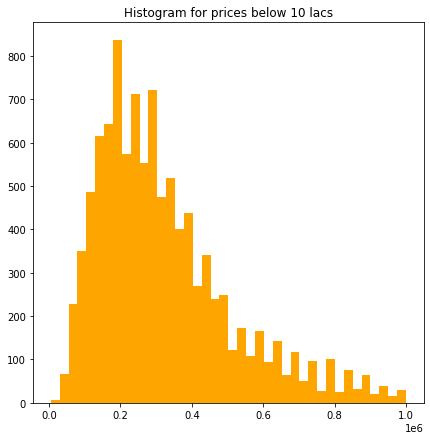

In [ ]:
price = super_df.price

p = []

for i in price:
  if i < 0.1e+07:
    p.append(i)

plt.figure(figsize = (7,7))
plt.hist(p, bins = 40, color = 'Orange')
plt.title('Histogram for prices below 10 lacs')
# price.mean()

Text(0.5, 1.0, 'Price distribution in data')

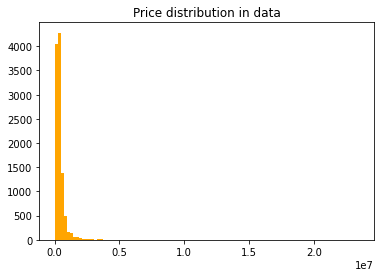

In [ ]:
plt.hist(price, bins = 100, color = 'Orange')
plt.title('Price distribution in data')

Text(0.5, 1.0, 'Bed vs Price')

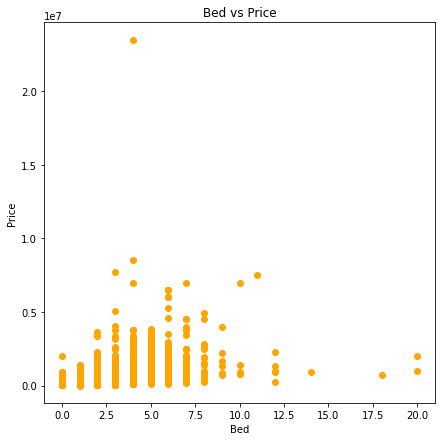

In [ ]:
plt.figure(figsize = (7,7))

plt.scatter(super_df.bed, super_df.price, color = 'Orange')
plt.xlabel('Bed')
plt.ylabel('Price')
plt.title('Bed vs Price')

Text(0.5, 1.0, 'Beds')

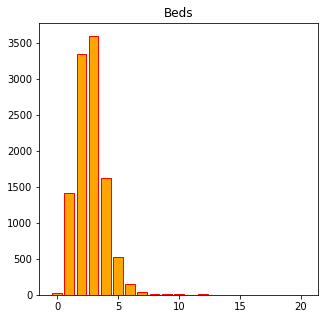

In [ ]:
plt.figure(figsize = (5,5))
plt.bar(Counter(super_df.bed).keys(), Counter(super_df.bed).values(), color = 'orange', edgecolor = 'red')
plt.title('Beds')

Text(0.5, 1.0, 'Lat lon distribution')

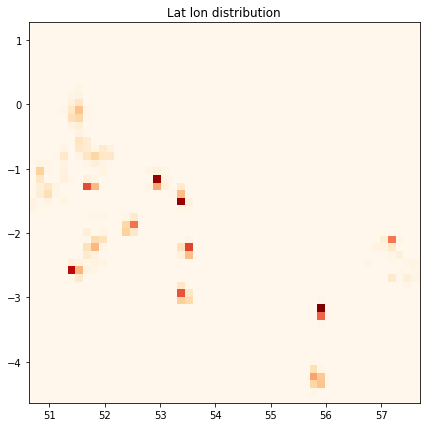

In [ ]:
plt.figure(figsize = (7,7))
plt.hist2d(super_df.lat, super_df.lon, bins = 50, cmap = 'OrRd')
plt.title('Lat lon distribution')

Text(0.5, 1.0, 'Price Statistics')

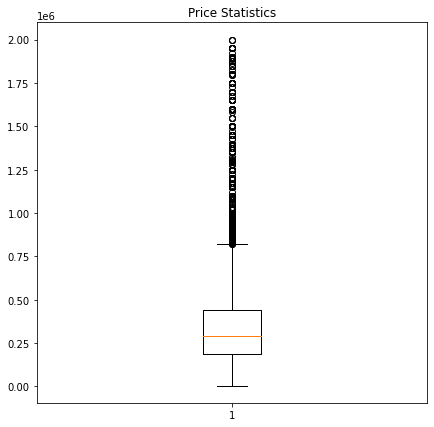

In [ ]:
p = []

for i in price:
  if i < 0.2e+07:
    p.append(i)


plt.figure(figsize = (7,7))
plt.boxplot(p)
plt.title('Price Statistics')

<Figure size 1800x3600 with 0 Axes>

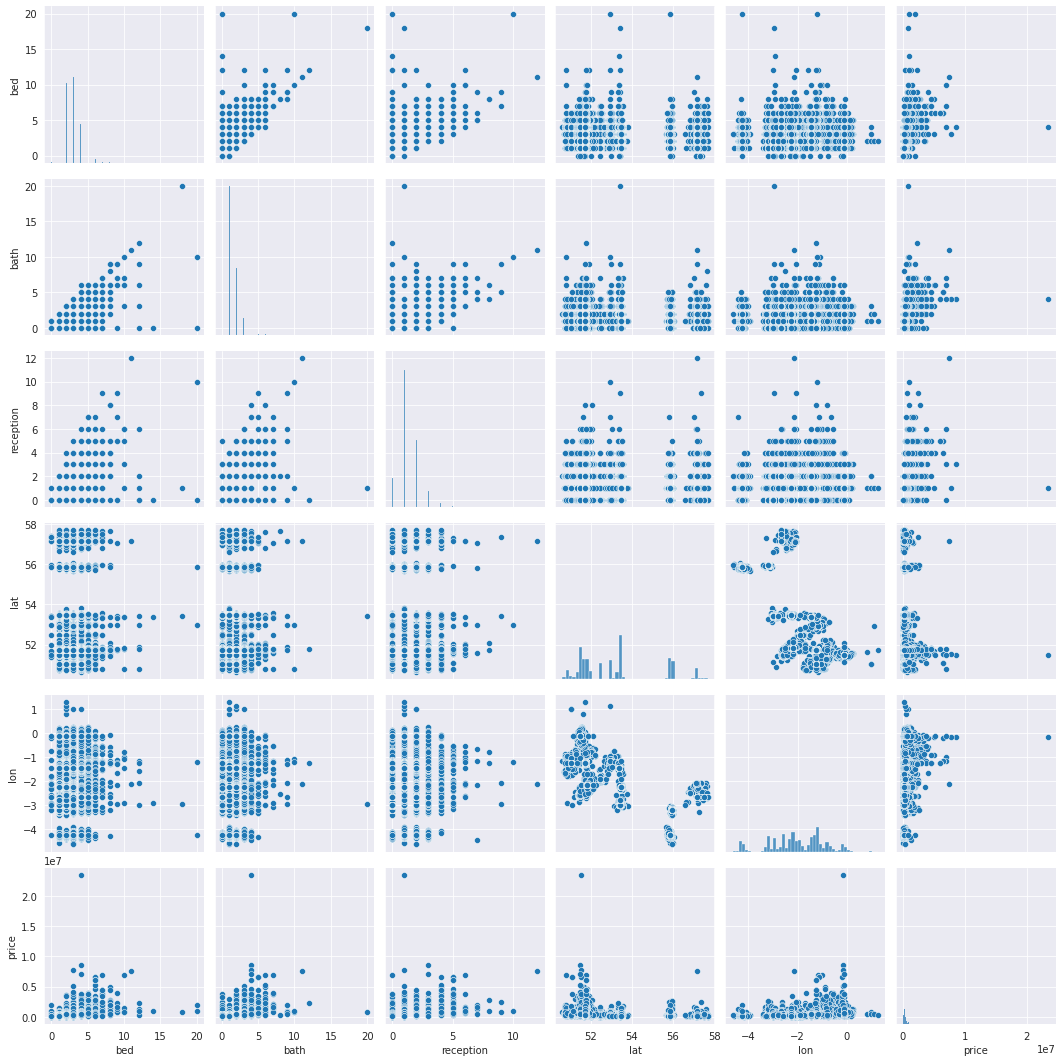

In [ ]:
plt.figure(figsize = (25,50))
sb.pairplot(super_df[['bed', 'bath', 'reception', 'lat', 'lon', 'price']])
plt.show()

## Saving the file

In [ ]:
# super_df.to_excel(os.path.join(os.getcwd(), 'drive', 'MyDrive', 'PC503_project', 'data', 'main_data_houses.xlsx'))

In [ ]:
import time
for k in city:
  x = f'https://eu1.locationiq.com/v1/search?key={api_key}&q={quote(k)}&format=json'
  y = requests.get(x)

  lat = float(y.json()[0]['lat'])
  lon = float(y.json()[0]['lon'])

  print(f'{k} -> {lat}, {lon}')
  time.sleep(1)

birmingham -> 52.4796992, -1.9026911
bristol -> 51.4538022, -2.5972985
buckinghamshire -> 51.7834994, -0.8946440535649794
edinburgh -> 55.9533456, -3.1883749
glasgow -> 55.8609825, -4.2488787
gloucestershire -> 51.8333313, -2.1666674
hampshire -> 51.04483545, -1.2434093597173146
liverpool -> 53.4071991, -2.99168
london -> 51.5073219, -0.1276474
nottingham -> 52.9534193, -1.1496461
oxford -> 51.7520131, -1.2578499
sheffield -> 53.3806626, -1.4702278
aberdeenshire -> 57.166667, -2.666667
manchester -> 53.4794892, -2.2451148
